In [2]:
from model import *
from train_in_roll import *
from dataloader import *
from utils import *
from collections import OrderedDict

In [ ]:
dataset = ImageDataSet(win_size=5, start_date=20091231, end_date=20111231, mode='train', indicators={'MA':[20]}, show_volume=True)
image_set = dataset.generate_images(0.04)

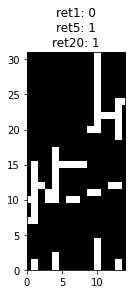

In [7]:
display_image(image_set[0])

In [96]:
TRIAN_VAL_SPLIT_RATIO = 0.7
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
LABEL_TYPE = 'RET1'

train_loader_size = int(len(image_set)*TRIAN_VAL_SPLIT_RATIO)
torch_loader_size = len(image_set) - train_loader_size

train_loader, val_loader = torch.utils.data.random_split(image_set, [train_loader_size, torch_loader_size])
train_loader = torch.utils.data.DataLoader(dataset=train_loader, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_loader, batch_size=BATCH_SIZE, shuffle=False)

In [107]:
for i, (input, ret1, ret5, ret20) in enumerate(val_loader):
    assert LABEL_TYPE in ['RET1', 'RET5', 'RET20'], f"Wrong Label Type: {LABEL_TYPE}"
    if LABEL_TYPE == 'RET1':
        labels = ret1
    elif LABEL_TYPE == 'RET5':
        labels = ret5
    else:
        labels = ret20

    labels = (1-labels).unsqueeze(1) @ torch.LongTensor([1., 0.]).unsqueeze(1).T + labels.unsqueeze(1) @ torch.LongTensor([0, 1]).unsqueeze(1).T
    labels = labels.to(torch.float32)
    break

In [108]:
input.shape

torch.Size([128, 32, 15])

In [110]:
conv1 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(1, 64, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1))), # output size: [N, 64, 32, 15]
            ('BN', nn.BatchNorm2d(64, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2,1))) # output size: [N, 64, 16, 15]
        ]))

In [133]:
class CNN5d(nn.Module):
    # Input: [N, (1), 32, 15]; Output: [N, 2]
    # Two Convolution Blocks
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    
    def __init__(self):
        super(CNN5d, self).__init__()
        self.conv1 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(1, 64, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1))), # output size: [N, 64, 32, 15]
            ('BN', nn.BatchNorm2d(64, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2,1))) # output size: [N, 64, 16, 15]
        ]))
        self.conv1 = self.conv1.apply(self.init_weights)
        
        self.conv2 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(64, 128, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1))), # output size: [N, 128, 16, 15]
            ('BN', nn.BatchNorm2d(128, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2,1))) # output size: [N, 128, 8, 15]
        ]))
        self.conv2 = self.conv2.apply(self.init_weights)

        self.DropOut = nn.Dropout(p=0.5)
        self.FC = nn.Linear(15360, 2)
        self.init_weights(self.FC)
        self.Softmax = nn.Softmax(dim=1)


    def forward(self, x): # input: [N, 32, 15]
        x = x.unsqueeze(1).to(torch.float32)   # output size: [N, 1, 32, 15]
        x = self.conv1(x) # output size: [N, 64, 16, 15]
        x = self.conv2(x) # output size: [N, 128, 8, 15]
        x = self.DropOut(x.view(x.shape[0], -1))
        x = self.FC(x) # output size: [N, 2]
        x = self.Softmax(x)
        
        return x

In [134]:
model5 = CNN5d()
model5

CNN5d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5, inplace=False)
  (FC): Linear(in_features=15360, out_features=2, bias=True)
  (Softmax): Softmax(dim=1)
)

In [92]:
cc = nn.Conv2d(1, 64, (5, 3), padding=(3, 1), stride=(3, 1), dilation=(2, 1))

In [93]:
isinstance(cc, nn.Conv2d)

True

In [136]:
class CNN20d(nn.Module):
    # Input: [N, (1), 64, 60]; Output: [N, 2]
    # Three Convolution Blocks
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    
    def __init__(self):
        super(CNN20d, self).__init__()
        self.conv1 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(1, 64, (5, 3), padding=(3, 1), stride=(3, 1), dilation=(2, 1))), # output size: [N, 64, 21, 60]
            ('BN', nn.BatchNorm2d(64, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2,1))) # output size: [N, 64, 10, 60]
        ]))
        self.conv1 = self.conv1.apply(self.init_weights)
        
        self.conv2 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(64, 128, (5, 3), padding=(3, 1), stride=(1, 1), dilation=(1, 1))), # output size: [N, 128, 12, 60]
            ('BN', nn.BatchNorm2d(128, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2,1))) # output size: [N, 128, 6, 60]
        ]))
        self.conv2 = self.conv2.apply(self.init_weights)
        
        self.conv3 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(128, 256, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1))), # output size: [N, 256, 6, 60]
            ('BN', nn.BatchNorm2d(256, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2,1))) # output size: [N, 256, 3, 60]
        ]))
        self.conv3 = self.conv3.apply(self.init_weights)

        self.DropOut = nn.Dropout(p=0.5)
        self.FC = nn.Linear(46080, 2)
        self.init_weights(self.FC)
        self.Softmax = nn.Softmax(dim=1)


    def forward(self, x): # input: [N, 64, 60]
        x = x.unsqueeze(1).to(torch.float32)   # output size: [N, 1, 64, 60]
        x = self.conv1(x) # output size: [N, 64, 10, 60]
        x = self.conv2(x) # output size: [N, 128, 6, 60]
        x = self.conv3(x) # output size: [N, 256, 3, 60]
        x = self.DropOut(x.view(x.shape[0], -1))
        x = self.FC(x) # output size: [N, 2]
        x = self.Softmax(x)
        
        return x

In [94]:
m = nn.Dropout(p=0.2)
input = torch.randn(20, 16)
output = m(input)

In [116]:
model20 = CNN20d()
model20

CNN20d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(3, 1), dilation=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(3, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (Conv): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5

In [ ]:
roll = [((20091231, 20111231), (20111231, 20121231))]
models = [CNN20d().to('cuda'),CNN20d().to('cuda'),CNN20d().to('cuda')]
train_model(models, train_loader, val_loader, num_epochs=10, learning_rate=0.001, batch_size=32, device='cuda' , weight_decay=0.0)

In [33]:
def train_one_epoch():
    print('train one epoch')
    return 

In [84]:
output = model5(input)

In [87]:
criterion = nn.BCELoss()

In [66]:
type(output)

torch.Tensor

In [86]:
loss(output, labels)

tensor(6.8413, grad_fn=<BinaryCrossEntropyBackward0>)